In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*8)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [31]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [51]:
def get_data(df):
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq] + [[0]*21]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.En.values]
    ec_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [54]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data(train)

aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data(val)

aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data(test)

In [55]:
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)

print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)

print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 40) (215352, 30, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352,)
(53838, 40) (53838, 30, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838,)
(67298, 40) (67298, 30, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298,)


# Compare : other model
  - 2019Bioinformatics : DeepMSpeptide 
    - Acc : 0.809, AUC : 0.871
  - CNN + LSTM
    - ACC : 0.832, AUC : 0.911  
  
  - 2019ACS : AP3 
    - Acc : 0.790, AUC : 0.875  
  
  - 2021ACS : PepFormer
    - Acc : 0.832, AUC : 0.906
  

2104/2104 [==============================] - 19s 9ms/step - loss: 0.3787 - accuracy: 0.8315
Test Loss: 0.37874361872673035
Test Accuracy: 0.8315402865409851
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     33706
           1       0.81      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9132060997321204


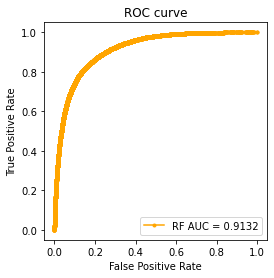

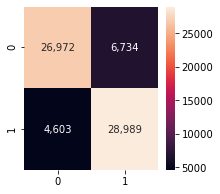

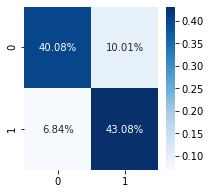

In [72]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()